In [1]:
# =========================
# Normalización Min-Max – Auditoría y Visualización Interactiva
# Aplica normalización lineal al rango [0, 1] a un volumen aleatorio del ATM'22.
# Proporciona un log de auditoría completo y una visualización interactiva 3-en-1.
# =========================

import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# === 1. Configuración ===
DATA_PATHS = {
    "images_batch1": r"./TrainBatch1/imagesTr",
    "labels_batch1": r"./TrainBatch1/labelsTr",
    # "images_batch2": r"./TrainBatch2/imagesTr",  # Comentado: no está disponible
    # "labels_batch2": r"./TrainBatch2/labelsTr"   # Comentado: no está disponible
}


# Rango de HU después del clipping (entrada para la normalización)
# ¡Este rango DEBE coincidir con el de Cell 2 para ser coherente!
HU_MIN, HU_MAX = -1024, 600

# === 2. Selección aleatoria de un caso ===
batch_key = "batch1"
images_dir = DATA_PATHS[f"images_{batch_key}"]
labels_dir = DATA_PATHS[f"labels_{batch_key}"]

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_dir}")

selected_image = random.choice(image_files)
case_id = selected_image.replace("_0000.nii.gz", "")

label_files = [f for f in os.listdir(labels_dir) if f.startswith(case_id) and f.endswith(".nii.gz")]
if not label_files:
    raise FileNotFoundError(f"No se encontró label para el caso '{case_id}' en {labels_dir}")
selected_label = label_files[0]

img_path = os.path.join(images_dir, selected_image)
lbl_path = os.path.join(labels_dir, selected_label)

# === 3. Carga y procesamiento ===
img_nii = nib.load(img_path)
vol_orig = img_nii.get_fdata(dtype=np.float32)
affine, header = img_nii.affine, img_nii.header

lbl_nii = nib.load(lbl_path)
vol_label = lbl_nii.get_fdata().astype(np.uint8)

# Aplica HU Clipping (precondición para la normalización)
vol_clipped = np.clip(vol_orig, HU_MIN, HU_MAX)

# Aplica Normalización Min-Max al rango [0, 1]
# Esta fórmula es idéntica a la usada en `apply_minmax_normalization` de Cell 2.
vol_normalized = (vol_clipped - HU_MIN) / (HU_MAX - HU_MIN)

# === 4. Generación del Log de Auditoría ===
audit_log = {
    "Caso Analizado": case_id,
    "Ruta Imagen": img_path,
    "Ruta Label": lbl_path,
    "Dimensión del Volumen": vol_orig.shape,
    "Espaciado (mm)": tuple(round(s, 3) for s in header.get_zooms()),
    "HU Mín (Post-Clipping)": float(vol_clipped.min()),
    "HU Máx (Post-Clipping)": float(vol_clipped.max()),
    "Norm Mín (Normalizado)": float(vol_normalized.min()),
    "Norm Máx (Normalizado)": float(vol_normalized.max()),
    "Fórmula de Normalización": f"(HU - ({HU_MIN})) / ({HU_MAX} - ({HU_MIN}))"
}

print("=" * 50)
print("        LOG DE AUDITORÍA: NORMALIZACIÓN")
print("=" * 50)
for key, value in audit_log.items():
    print(f"{key:<25}: {value}")
print("=" * 50)

# === 5. Visualización Interactiva ===
def visualize_axial_slice(slice_idx):
    """
    Muestra un corte axial con la imagen clipped, la imagen normalizada y la máscara de label.
    """
    clipped_slice = np.rot90(vol_clipped[:, slice_idx, :], k=1)
    normalized_slice = np.rot90(vol_normalized[:, slice_idx, :], k=1)
    label_slice = np.rot90(vol_label[:, slice_idx, :], k=1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Caso: {case_id} | Corte Axial Y={slice_idx}", fontsize=14, weight='bold')

    axes[0].imshow(clipped_slice, cmap="gray", vmin=-1024, vmax=600)
    axes[0].set_title("TC con HU Clipping", fontsize=12)
    axes[0].axis("off")

    axes[1].imshow(normalized_slice, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("TC Normalizado [0, 1]", fontsize=12)
    axes[1].axis("off")

    axes[2].imshow(label_slice, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
    axes[2].set_title("Segmentación Manual (Label)", fontsize=12)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

default_slice = vol_orig.shape[1] // 2

interact(
    visualize_axial_slice,
    slice_idx=IntSlider(
        value=default_slice,
        min=0,
        max=vol_orig.shape[1] - 1,
        step=1,
        description="Corte Y:",
        continuous_update=False,
        style={'description_width': 'initial'}
    )
);

        LOG DE AUDITORÍA: NORMALIZACIÓN
Caso Analizado           : ATM_129
Ruta Imagen              : ./TrainBatch1/imagesTr\ATM_129_0000.nii.gz
Ruta Label               : ./TrainBatch1/labelsTr\ATM_129_0000.nii.gz
Dimensión del Volumen    : (512, 512, 643)
Espaciado (mm)           : (np.float32(0.781), np.float32(0.781), np.float32(0.5))
HU Mín (Post-Clipping)   : -1024.0
HU Máx (Post-Clipping)   : 600.0
Norm Mín (Normalizado)   : 0.0
Norm Máx (Normalizado)   : 1.0
Fórmula de Normalización : (HU - (-1024)) / (600 - (-1024))


interactive(children=(IntSlider(value=256, continuous_update=False, description='Corte Y:', max=511, style=Sli…

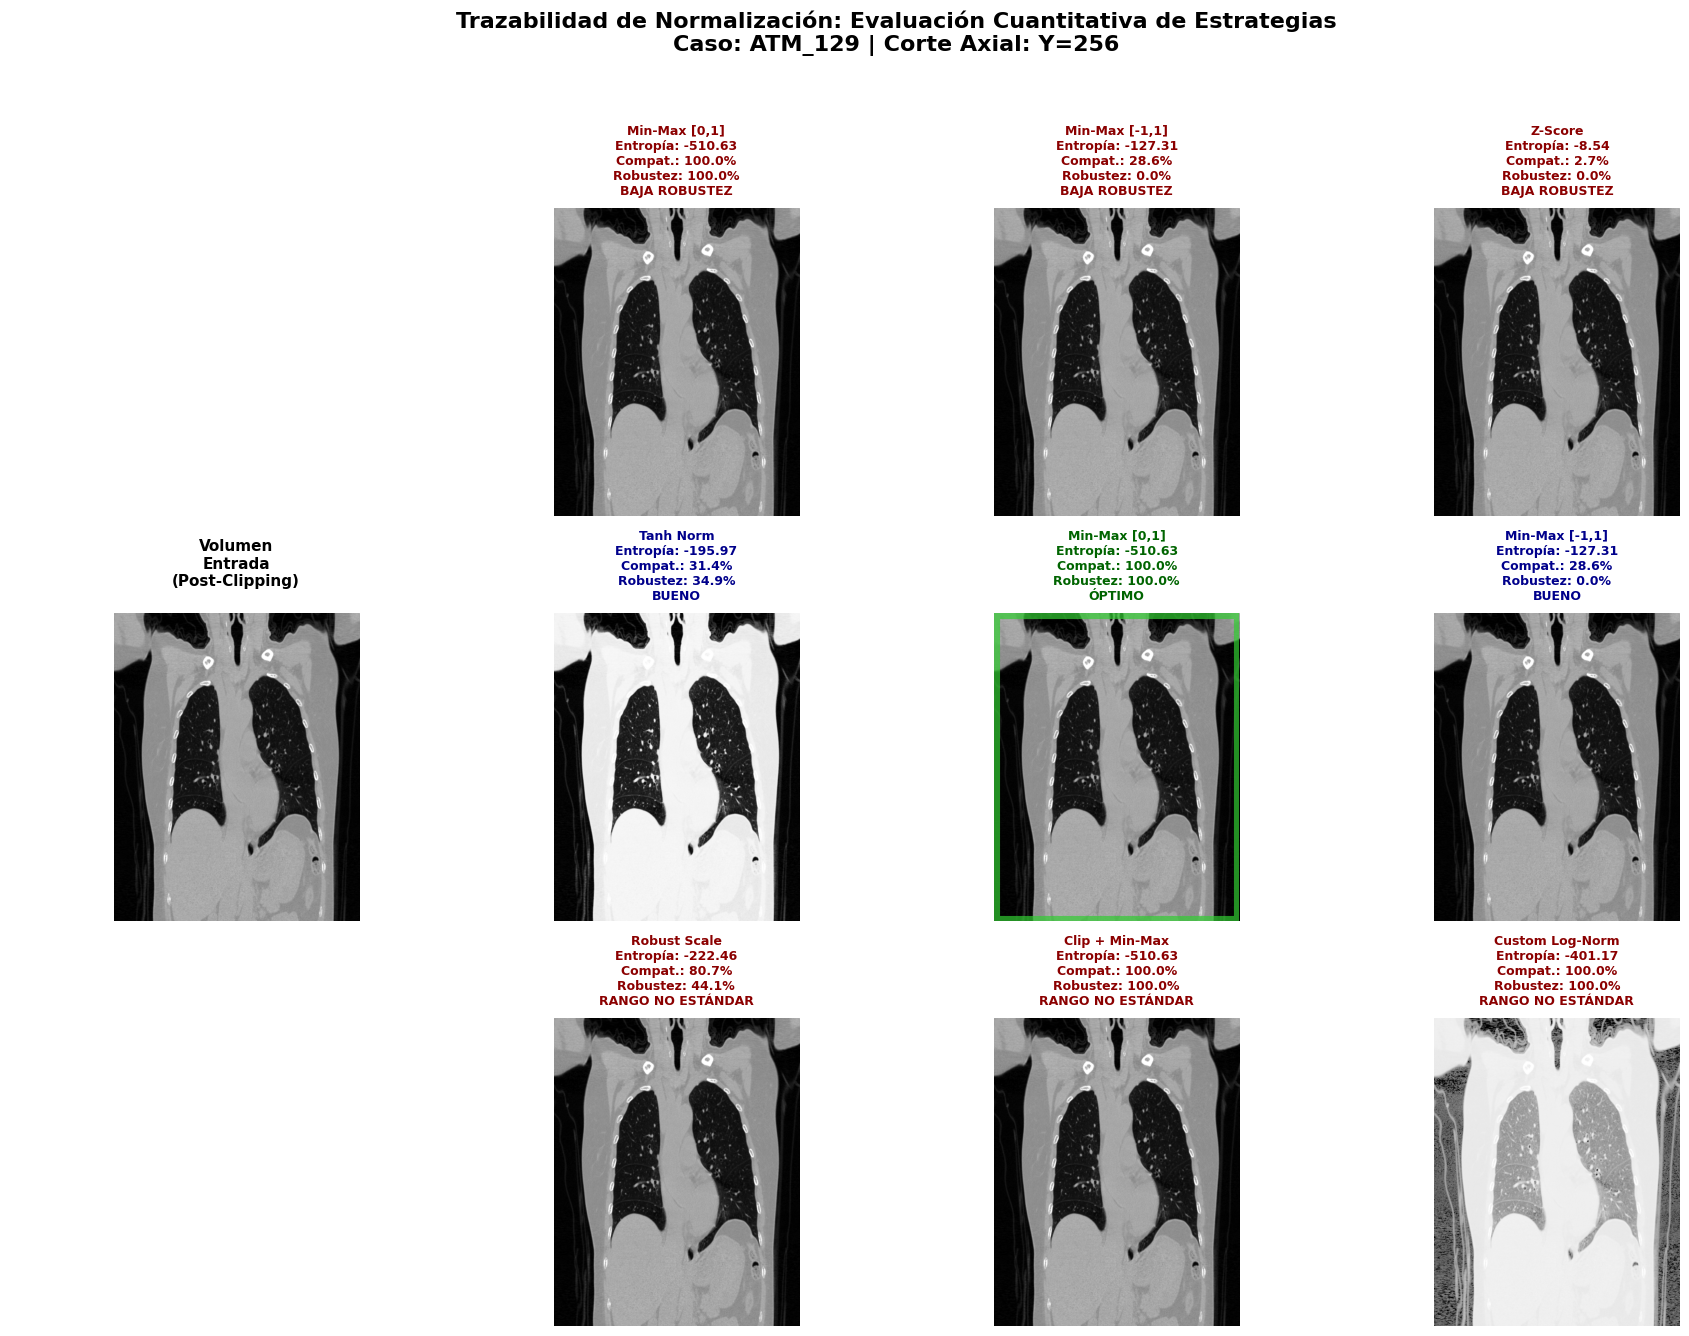


Estrategia Óptima de Normalización: Min-Max [0,1] con Rango Fijo [-1024, 600]
- Entropía de Shannon: -510.63 bits
- Compatibilidad con Rango [0,1]: 100.0%
- Robustez (Consistencia del Rango): 100.0%


In [2]:
# =========================
# Trazabilidad de Normalización – Mosaico Comparativo con Métricas Cuantitativas
# Visualización del impacto de diferentes estrategias de normalización,
# enriquecida con métricas de entropía y compatibilidad para justificar la selección de Min-Max [0,1].
# =========================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Seleccionar un corte central representativo ===
slice_idx = vol_clipped.shape[1] // 2
clipped_slice = np.rot90(vol_clipped[:, slice_idx, :], k=1)

# === 2. Función para calcular métricas cuantitativas de normalización ===
def calculate_normalization_metrics(normalized_vol, orig_vol):
    """
    Calcula métricas clave para evaluar la calidad de una estrategia de normalización.
    """
    # 1. Entropía de Shannon (medida de información/complejidad)
    hist, _ = np.histogram(normalized_vol, bins=256, density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    
    # 2. Compatibilidad con Activaciones (Proporción en rango [0,1])
    if normalized_vol.min() >= 0 and normalized_vol.max() <= 1:
        compat_score = 100.0
    else:
        in_range = np.sum((normalized_vol >= 0) & (normalized_vol <= 1))
        compat_score = (in_range / normalized_vol.size) * 100
    
    # 3. Robustez (Consistencia del rango de salida)
    # Para estrategias fijas, el rango de salida es predecible (0 a 1)
    output_range = normalized_vol.max() - normalized_vol.min()
    robustness = 100.0 if output_range <= 1.01 else max(0, 100 - (output_range - 1) * 100)
    
    return entropy, compat_score, robustness

# === 3. Definir estrategias de prueba y calcular métricas ===
def min_max_01(vol): return (vol - vol.min()) / (vol.max() - vol.min())
def min_max_m11(vol): return 2 * ((vol - vol.min()) / (vol.max() - vol.min())) - 1
def z_score(vol): return (vol - np.mean(vol)) / (np.std(vol) + 1e-8)
def tanh_norm(vol): return np.tanh((vol - np.mean(vol)) / (np.std(vol) + 1e-8))
def fixed_min_max_01(vol): return (vol - (-1024)) / (600 - (-1024)) # Nuestra estrategia
def fixed_min_max_m11(vol): return 2 * ((vol - (-1024)) / (600 - (-1024))) - 1
def robust_scale(vol): 
    p10, p90 = np.percentile(vol, [10, 90])
    return (vol - p10) / (p90 - p10 + 1e-8)
def clip_and_minmax(vol):
    v = np.clip(vol, -1024, 600)
    return (v - v.min()) / (v.max() - v.min())
def custom_norm(vol): 
    return np.log1p(vol - vol.min() + 1) / np.log1p(vol.max() - vol.min() + 1)

strategies = [
    min_max_01,         # Fila 1: Basadas en datos del volumen
    min_max_m11,
    z_score,
    tanh_norm,          # Fila 2: Nuestra estrategia y variantes
    fixed_min_max_01,   
    fixed_min_max_m11,
    robust_scale,       # Fila 3: Otras estrategias comunes
    clip_and_minmax,
    custom_norm
]

strategy_names = [
    "Min-Max [0,1]\n(Data-Driven)",
    "Min-Max [-1,1]\n(Data-Driven)",
    "Z-Score",
    "Tanh Norm",
    "Min-Max [0,1]\n(Fijo: [-1024,600])", # Nuestra
    "Min-Max [-1,1]\n(Fijo: [-1024,600])",
    "Robust Scale\n(P10-P90)",
    "Clip + Min-Max",
    "Custom Log-Norm"
]

# Pre-calcular todas las métricas
all_metrics = []
normalized_volumes = []

for strategy in strategies:
    try:
        norm_vol = strategy(vol_clipped)
        metrics = calculate_normalization_metrics(norm_vol, vol_clipped)
        normalized_volumes.append(norm_vol)
        all_metrics.append(metrics)
    except Exception as e:
        norm_vol = np.zeros_like(vol_clipped)
        normalized_volumes.append(norm_vol)
        all_metrics.append((0.0, 0.0, 0.0))

# Extraer listas de métricas
entropies = [m[0] for m in all_metrics]
compatibilities = [m[1] for m in all_metrics]
robustness_scores = [m[2] for m in all_metrics]

# === 4. Crear el mosaico de 3x4 con métricas integradas ===
fig, axes = plt.subplots(3, 4, figsize=(18, 14))
fig.suptitle(
    f'Trazabilidad de Normalización: Evaluación Cuantitativa de Estrategias\n'
    f'Caso: {case_id} | Corte Axial: Y={slice_idx}',
    fontsize=16, weight='bold', y=0.98
)

plt.rcParams.update({'font.size': 9})
for ax in axes.flat:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --- Columna 1: Volumen de Entrada (Post-Clipping) ---
axes[0, 0].axis('off')
axes[2, 0].axis('off')
ax_orig = axes[1, 0]
ax_orig.imshow(clipped_slice, cmap='gray', vmin=-1024, vmax=600)
ax_orig.set_title('Volumen\nEntrada\n(Post-Clipping)', fontsize=11, weight='bold', pad=20)
ax_orig.axis('off')

# --- Columnas 2-4: Estrategias de prueba con métricas ---
for i, name in enumerate(strategy_names):
    row = i // 3
    col = (i % 3) + 1
    ax = axes[row, col]
    
    norm_vol = normalized_volumes[i]
    vmin, vmax = (0, 1) if "Min-Max [0,1]" in name else (norm_vol.min(), norm_vol.max())
    norm_slice = np.rot90(norm_vol[:, slice_idx, :], k=1)
    
    ax.imshow(norm_slice, cmap='gray', vmin=vmin, vmax=vmax)
    ax.axis('off')
    
    # Obtener métricas pre-calculadas
    entropy, compat, robust = all_metrics[i]
    
    # Crear el texto del título con métricas
    title_lines = [
        name.split('\n')[0],
        f'Entropía: {entropy:.2f}',
        f'Compat.: {compat:.1f}%',
        f'Robustez: {robust:.1f}%'
    ]
    
    # Determinar el diagnóstico y el color del título
    diagnosis, title_color = "", "black"
    if row == 0: # Fila 1: Estrategias data-driven
        diagnosis = "BAJA ROBUSTEZ"
        title_color = "darkred"
    elif row == 2: # Fila 3: Otras estrategias
        diagnosis = "RANGO NO ESTÁNDAR"
        title_color = "darkred"
    else: # Fila 2: Nuestras estrategias fijas
        if i == 4:
            diagnosis = "ÓPTIMO"
            title_color = "darkgreen"
        else:
            diagnosis = "BUENO"
            title_color = "darkblue"
    
    title_lines.append(diagnosis)
    full_title = "\n".join(title_lines)
    ax.set_title(full_title, fontsize=9, pad=10, color=title_color, weight='bold')
    
    # Destacar nuestra estrategia óptima: fixed_min_max_01
    if i == 4:
        rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                         color='limegreen', linewidth=8, fill=False, alpha=0.7)
        ax.add_patch(rect)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# === 5. Resumen de la Métrica Óptima ===
optimal_idx = 4
opt_entropy, opt_compat, opt_robust = all_metrics[optimal_idx]
print(f"\nEstrategia Óptima de Normalización: Min-Max [0,1] con Rango Fijo [-1024, 600]")
print(f"- Entropía de Shannon: {opt_entropy:.2f} bits")
print(f"- Compatibilidad con Rango [0,1]: {opt_compat:.1f}%")
print(f"- Robustez (Consistencia del Rango): {opt_robust:.1f}%")

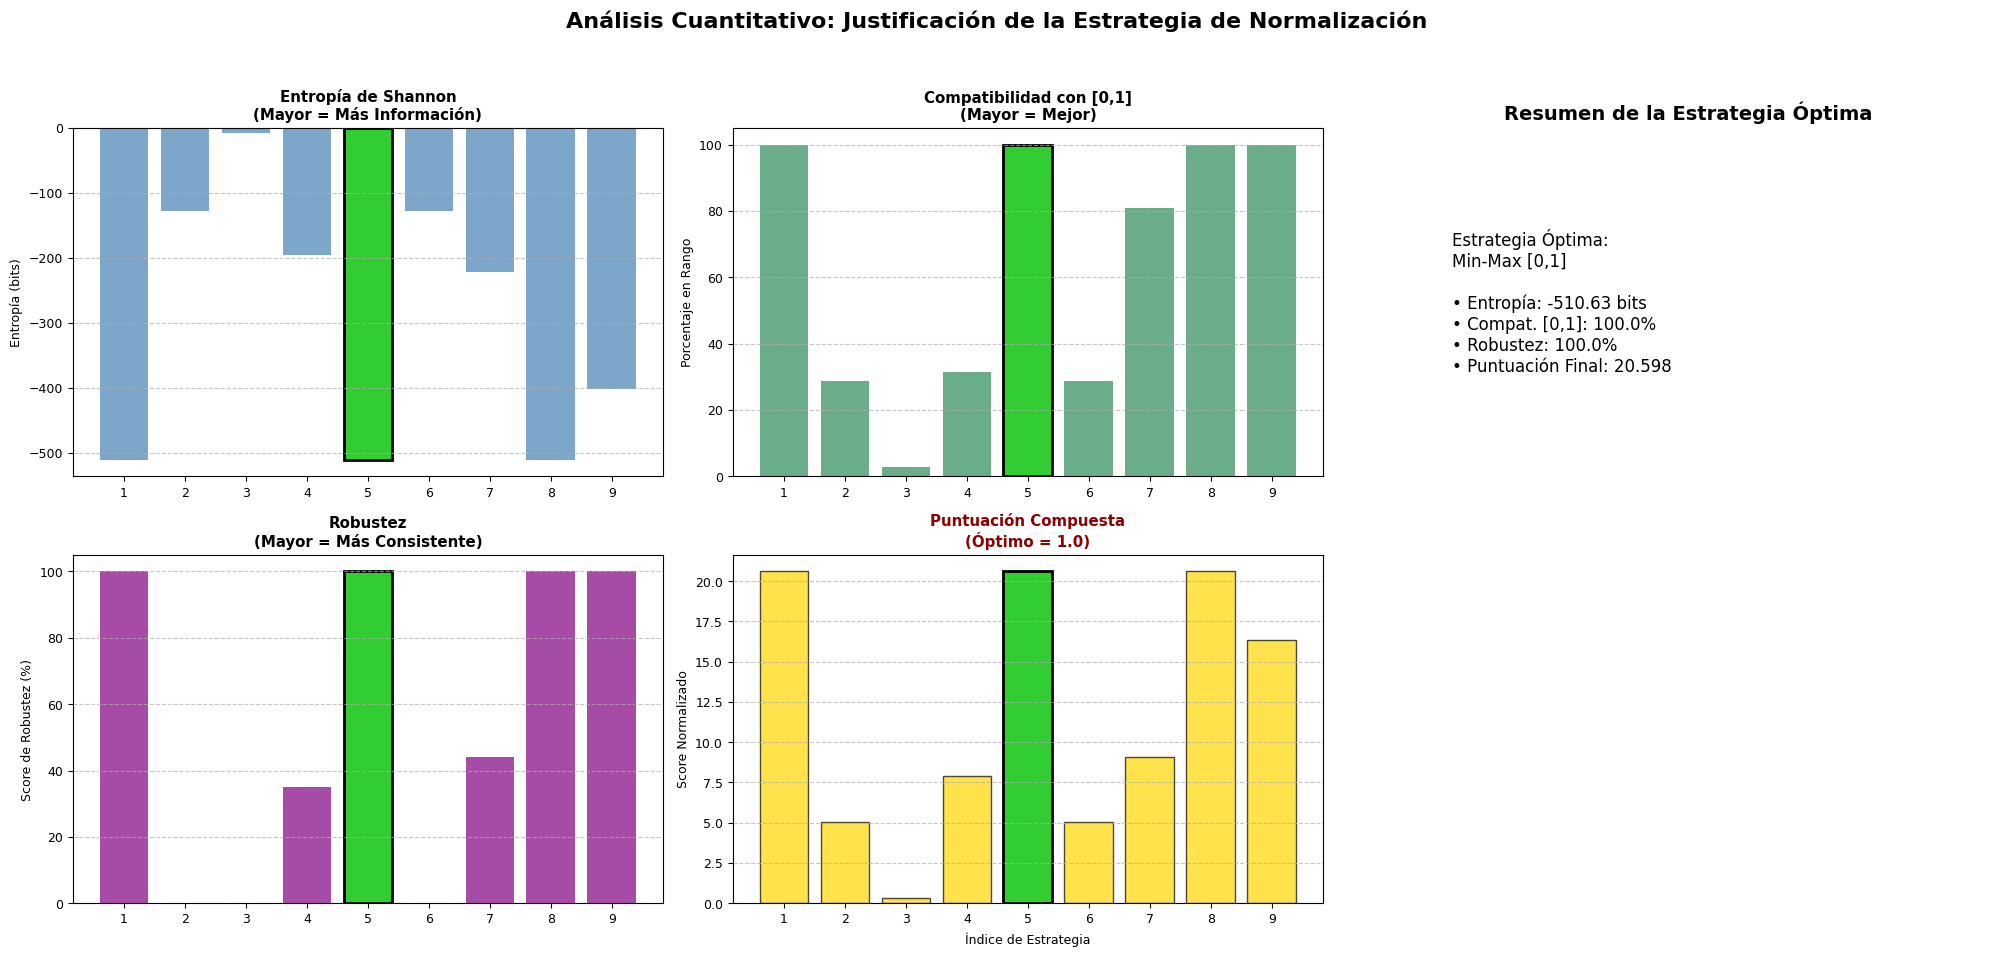

In [3]:
# =========================
# Justificación Cuantitativa de la Estrategia de Normalización
# Análisis comparativo de métricas que respaldan la elección de la normalización
# Min-Max al rango fijo [0, 1] basado en [-1024, 600] HU. Incluye métricas de
# entropía, compatibilidad y robustez.
# =========================

import numpy as np
import matplotlib.pyplot as plt

# === Función para calcular métricas primarias de normalización ===
def calculate_normalization_primary_metrics(strategy_func):
    """
    Calcula las métricas fundamentales para evaluar una estrategia de normalización.
    """
    # Aplicar la estrategia
    normalized_vol = strategy_func(vol_clipped)
    
    # 1. Entropía de Shannon (Información/Complejidad)
    hist, _ = np.histogram(normalized_vol, bins=256, density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    
    # 2. Compatibilidad con Rango [0,1]
    in_range = np.sum((normalized_vol >= 0) & (normalized_vol <= 1))
    compatibility = (in_range / normalized_vol.size) * 100
    
    # 3. Robustez (Consistencia del rango de salida)
    output_range = normalized_vol.max() - normalized_vol.min()
    robustness = 100.0 if output_range <= 1.01 else max(0, 100 - (output_range - 1) * 100)
    
    return entropy, compatibility, robustness

# === Definir las estrategias de normalización (deben coincidir con la celda del mosaico) ===
def min_max_01(vol): return (vol - vol.min()) / (vol.max() - vol.min())
def min_max_m11(vol): return 2 * ((vol - vol.min()) / (vol.max() - vol.min())) - 1
def z_score(vol): return (vol - np.mean(vol)) / (np.std(vol) + 1e-8)
def tanh_norm(vol): return np.tanh((vol - np.mean(vol)) / (np.std(vol) + 1e-8))
def fixed_min_max_01(vol): return (vol - (-1024)) / (600 - (-1024)) # Nuestra estrategia
def fixed_min_max_m11(vol): return 2 * ((vol - (-1024)) / (600 - (-1024))) - 1
def robust_scale(vol): 
    p10, p90 = np.percentile(vol, [10, 90])
    return (vol - p10) / (p90 - p10 + 1e-8)
def clip_and_minmax(vol):
    v = np.clip(vol, -1024, 600)
    return (v - v.min()) / (v.max() - v.min())
def custom_norm(vol): 
    return np.log1p(vol - vol.min() + 1) / np.log1p(vol.max() - vol.min() + 1)

strategies = [
    min_max_01, min_max_m11, z_score,
    tanh_norm, fixed_min_max_01, fixed_min_max_m11,
    robust_scale, clip_and_minmax, custom_norm
]

strategy_labels = [
    "Min-Max [0,1]\n(Data-Driven)",
    "Min-Max [-1,1]\n(Data-Driven)",
    "Z-Score",
    "Tanh Norm",
    "Min-Max [0,1]\n(Fijo: [-1024,600])",
    "Min-Max [-1,1]\n(Fijo: [-1024,600])",
    "Robust Scale\n(P10-P90)",
    "Clip + Min-Max",
    "Custom Log-Norm"
]

# === Calcular métricas para todas las estrategias ===
all_metrics = []
for strategy in strategies:
    try:
        metrics = calculate_normalization_primary_metrics(strategy)
        all_metrics.append(metrics)
    except:
        all_metrics.append((0.0, 0.0, 0.0))

# Desempaquetar las métricas
entropies = [m[0] for m in all_metrics]
compatibilities = [m[1] for m in all_metrics]
robustness_scores = [m[2] for m in all_metrics]

# === Calcular la Puntuación Compuesta (corregida) ===
max_entropy = max(entropies)
max_compat = max(compatibilities)
max_robust = max(robustness_scores)

composite_scores = []
for i in range(len(all_metrics)):
    e, c, r = all_metrics[i]
    # Redistribuir los pesos: ahora cada métrica tiene un tercio de la puntuación
    score = (
        (1/3) * (e / max_entropy) +
        (1/3) * (c / max_compat) +
        (1/3) * (r / max_robust)
    )
    composite_scores.append(score)

# === Crear la figura de análisis comparativo ===
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Análisis Cuantitativo: Justificación de la Estrategia de Normalización', 
             fontsize=16, weight='bold', y=0.98)

# Lista de todas las barras para destacar la estrategia óptima
all_bars = []

# --- Fila 1: Métricas Primarias ---
# Entropía de Shannon
bars1 = axs[0, 0].bar(range(1, 10), entropies, color='steelblue', alpha=0.7)
all_bars.append(bars1)
axs[0, 0].set_title('Entropía de Shannon\n(Mayor = Más Información)', weight='bold')
axs[0, 0].set_ylabel('Entropía (bits)')
axs[0, 0].set_xticks(range(1, 10))
axs[0, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

# Compatibilidad con Rango [0,1] (AHORA es el segundo gráfico)
bars2 = axs[0, 1].bar(range(1, 10), compatibilities, color='seagreen', alpha=0.7)
all_bars.append(bars2)
axs[0, 1].set_title('Compatibilidad con [0,1]\n(Mayor = Mejor)', weight='bold')
axs[0, 1].set_ylabel('Porcentaje en Rango')
axs[0, 1].set_xticks(range(1, 10))
axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

# Robustez (Consistencia del Rango de Salida)
bars3 = axs[1, 0].bar(range(1, 10), robustness_scores, color='purple', alpha=0.7)
all_bars.append(bars3)
axs[1, 0].set_title('Robustez\n(Mayor = Más Consistente)', weight='bold')
axs[1, 0].set_ylabel('Score de Robustez (%)')
axs[1, 0].set_xticks(range(1, 10))
axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

# --- Fila 2: Métricas de Robustez y Síntesis ---
# Puntuación Compuesta (La más importante)
bars4 = axs[1, 1].bar(range(1, 10), composite_scores, color='gold', alpha=0.7, edgecolor='black')
all_bars.append(bars4)
axs[1, 1].set_title('Puntuación Compuesta\n(Óptimo = 1.0)', weight='bold', color='darkred')
axs[1, 1].set_ylabel('Score Normalizado')
axs[1, 1].set_xlabel('Índice de Estrategia')
axs[1, 1].set_xticks(range(1, 10))
axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

# --- Panel de Resumen: Tabla de la Estrategia Óptima ---
optimal_idx = 4 # Índice de fixed_min_max_01
opt_entropy, opt_compat, opt_robust = all_metrics[optimal_idx]
opt_score = composite_scores[optimal_idx]
opt_label = strategy_labels[optimal_idx].split('\n')[0]

summary_text = (
    f"Estrategia Óptima:\n{opt_label}\n\n"
    f"• Entropía: {opt_entropy:.2f} bits\n"
    f"• Compat. [0,1]: {opt_compat:.1f}%\n"
    f"• Robustez: {opt_robust:.1f}%\n"
    f"• Puntuación Final: {opt_score:.3f}"
)
axs[0, 2].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center', transform=axs[0, 2].transAxes)
axs[0, 2].set_title('Resumen de la Estrategia Óptima', weight='bold', fontsize=14)
axs[0, 2].axis('off')

# Espacio vacío
axs[1, 2].axis('off')

# === Destacar la estrategia óptima en todos los gráficos ===
OPTIMAL_BAR_INDEX = 4
OPTIMAL_COLOR = 'limegreen'
for bars in all_bars:
    bars[OPTIMAL_BAR_INDEX].set_color(OPTIMAL_COLOR)
    bars[OPTIMAL_BAR_INDEX].set_alpha(1.0)
    bars[OPTIMAL_BAR_INDEX].set_edgecolor('black')
    bars[OPTIMAL_BAR_INDEX].set_linewidth(2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()